In [154]:
import numpy as np
import pandas as pd
from quasinet.qnet import qdistance, load_qnet
from emergenet.domseq import DomSeq, save_model, load_model
import os
import shutil
import glob
from Levenshtein import distance as edit_distance

In [155]:
RBD=[63,286]
#RBD=[120,220]
#RBD=[350,520]
#RBD=[1,50]


In [156]:
IRATseq=glob.glob('../../irat_qnet/raw_data/irat_sequences/*ha.fasta')
R={}

def func(a):
    return np.mean(a)

for PATH in IRATseq:
    #print(PATH)
    seqname=PATH.split('/')[-1].replace(':','_')
    domseq = DomSeq(seq_trunc_length=550, random_state=42)
    r0 = domseq.load_data(filepath=PATH)
    r0=r0.set_index('id').sequence.values
    r0_=''.join(list(r0[0])[RBD[0]:RBD[1]])
    
    S=-1
    if os.path.exists(PATH.replace('irat_sequences','gisaid')):
        domseq = DomSeq(seq_trunc_length=550, random_state=42)
        df_ = domseq.load_data(filepath=PATH.replace('irat_sequences','gisaid'))
        seq=df_.set_index('id').sequence.values
        S=func(np.array([edit_distance(r0_,''.join(list(x)[RBD[0]:RBD[1]])) for x in seq]))
    
    R[seqname]=-S

In [157]:
lf=pd.DataFrame.from_dict([R]).transpose()
lf.columns=['ld']
lf.index=[x.replace('_','/').replace('/ha.fasta','') for x in lf.index.values]
lf

,ld
A/American green-winged teal/Washington/1957050/2014,-32.415385
A/American wigeon/South Carolina/AH0195145/2021,-33.763473
A/Anhui-Lujiang/39/2018,-21.033333
A/Astrakhan/3212/2020,-30.385827
A/Bangladesh/0994/2011,-28.666667
A/California/62/2018,-33.418182
A/Hong Kong/125/2017,-1.800915
A/Indiana/08/2011,-39.060052
A/Jiangxi-Donghu/346/2013,1.000000
A/Netherlands/219/2003,-8.891304


In [161]:
df=pd.read_csv('/home/ishanu/ZED/Research/emergenet/irat_qnet/results/fulldataframe.csv',index_col=0).set_index('strain')
#df=df[['subtype', 'IRAT assessment date', 'IRAT Emergence Estimate',
#       'IRAT Impact Estimate']]
df=df[['IRAT Emergence Estimate',
       'IRAT Impact Estimate']]
df=df.join(lf)
df=df[df.ld<0]
rf=df.copy()

In [162]:
import seaborn as sns
from zedstat.ci import ci
import pylab as plt
from jupyterthemes import jtplot
jtplot.style()


aic:  72.77171117606274 p-value:  0.3642305828832735 correlation:  0.20857809288517903


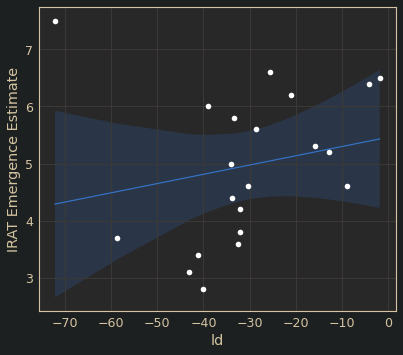

In [165]:
xvar='ld'
yvar='IRAT Emergence Estimate'
pred,pval,aic,corr,est=ci(rf,xvar,yvar,alpha=.05)
fig, ax = plt.subplots()
plt.fill_between(pred.index,pred.ub,pred.lb,alpha=.2)
pred.pred.plot()
rf.set_index(xvar)[yvar].plot(style='wo')
plt.gca().set_ylabel(yvar)
print('aic: ',aic,'p-value: ',pval,'correlation: ',corr)

pred=pred.rename(columns={'pred':'pred_GM','ub':'ub_GM','lb':'lb_GM'})
rf0=rf.join(pred,on=xvar)